<a href="https://colab.research.google.com/github/cpython-projects/da_1709/blob/main/lesson_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from google.colab import files
import plotly.express as px
import plotly.graph_objects as go
from google.colab import files

import warnings
warnings.filterwarnings("ignore")

# **1. Что такое сезонность**

## 1.1 Определения

Когда мы говорим о сезонности, мы говорим **не о календарных временах года**, а о повторяющихся циклах в данных. Это может быть что угодно: час, день, неделя, месяц, квартал или даже 10-минутные интервалы — если в них есть устойчивый паттерн.

**Сезонность** — это повторяющийся и устойчивый паттерн поведения временного ряда, который возникает с фиксированной периодичностью.  
То есть — это что-то, что повторяется *регулярно и предсказуемо*.

**Временной ряд (time series)** — это набор значений, упорядоченных по времени, обычно с фиксированной частотой (час, день, неделя, месяц).
Самое главное свойство: порядок времени имеет смысл, и переставлять строки нельзя.

Сезонность — это одна из ключевых вещей, без которых **невозможно делать правильный анализ данных**.

  
**Сезонность помогает**:

1.  Предсказывать загрузку и спрос   
    Пример: у энергетического оператора каждый день в 19:00 фиксируется пик потребления. Это стабильно из года в год → значит, можно планировать генерацию мощности.

2.  Находить аномалии  
    Если обычно в субботу трафик в 1.8–2.2 раза выше, а сегодня он вдруг ниже → это повод расследовать.  
    TSA Air Travel Data (США) показывает колоссальный спад полётов 25 декабря каждый год → если в один год резкого спада нет — это аномалия.
3.  Оптимизировать бюджеты  
    Ритейл Walmart показывает пик продаж в ноябре–декабре (Black Friday → Christmas). Если маркетолог «забудет» про сезонность, то он просто сольёт бюджет в октябре.
4.  Улучшать прогнозные модели  
    Модели ARIMA, Prophet и даже линейная регрессия требуют **dummies по месяцам/дням недели**.

## 1.2 Какие типы сезонности бывают и как их отличать

Сезонность бывает нескольких видов. Самый важный критерий — **период повторения паттерна**.
В Pandas отличить тип сезонности можно по группировкам по времени, а на графиках — по повторяющимся пикам/провалам.

---

### 1. Ежедневная (внутрисуточная) сезонность

Период: 24 часа  
Повторяющиеся паттерны внутри дня.

#### Примеры

* Потребление электроэнергии PJM: **пик вечером (18–20 часов), минимум ночью (3–5 часов)**.
* Трафик сайта: пики утром и вечером, провал глубокой ночью.
* Поездки Uber: пик ночью в пятницу/субботу, провал утром.

**Признак:** на графике чёткий «волнообразный» цикл в пределах суток.

---

### 2. Еженедельная сезонность

Период: 7 дней  
Повторение по дням недели.  

#### Примеры

* Трафик сайта: **будни < выходные** (когда люди дома).
* Посещаемость спортзалов: **понедельник — самый загруженный день**, суббота — спад.
* Пассажиропоток TSA: суббота — минимум.

**Признак:** одни дни недели стабильно высокие, другие — стабильно низкие.

---

### 3. Ежемесячная сезонность

Период: 12 месяцев  
Повторение: каждый год одни и те же месяцы повторяются с пиками и провалами

#### Примеры

* Продажи Walmart: пик ноябрь–декабрь.
* Потребление газа: пик зимой.
* Туризм: пик летом.


**Признак:** на графике одни месяцы всегда выше других.

---

### Ежегодная сезонность

Период: 1 год   
Повторение по годам на больших интервалах.   

Это редкий случай в обычном бизнес-аналитике, но встречается при:
* многолетней статистике погоды
* макроэкономических данных
* сельском хозяйстве (урожайность)

**Признак:** данные колеблются год к году, но не случайно, а повторяются по циклам.

---

### 5. “Нестандартная” сезонность (цикл ≠ календарю)

Период определяется не датой, а бизнес-процессом  

#### Примеры

* Call-центр: смены по 6 часов → цикл = 6 часов.
* Производство: 4 смены → цикл = 8 часов.
* Мобильная игра: ивенты каждую пятницу → цикл = 7 дней.
* Загрузка курьерской службы: пики перед 18:00, когда закрываются магазины.

**Признак:** данные “дышат” в рамках внутренних циклов компании.

---

### 6. Множественная сезонность

Период: несколько циклов одновременно  

#### Примеры

* Электричество: внутрисуточная + сезон года.
* Трафик сайта: ежедневная + недельная.
* Продажи: месячная + внутринедельная.

То есть в данных есть несколько паттернов:  
📉 каждый день своя мини-волна  
📉 каждую неделю есть воскресенье  
📈 каждый декабрь — пик продаж  

**Признак:** график выглядит как «волна внутри волны».


## Главный критерий: повторяемость

Сезонность — это не просто “вчера был пик, сегодня провал”.

Она должна:
* повторяться
* быть регулярной
* иметь фиксированный период

И только тогда это сезонность, а не шум или тренд.

# **2. Подготовка временных данных в Pandas**

In [ ]:
data = [
    {"date": "2024/01/01", "value": 103.1},
    {"date": "2024/01/02", "value": 100.4},
    {"date": "2024/01/04", "value": 111.8},  # 01-03 пропущен
    {"date": "2024/01/05", "value": 99.7},
    {"date": "2024/01/06", "value": 95.1},
    {"date": "2024/01/07", "value": 104.3},
    {"date": "01-15-2024", "value": 98.5},   # другой формат
    {"date": "2024/01/08", "value": 105.2},
    {"date": "2024/01/08", "value": 105.2},  # дубль
    {"date": "2024/01/09", "value": 110.1},
    {"date": "2024.02.03", "value": 120.7},  # другой формат
    {"date": "2024/02/04", "value": 98.2},
    {"date": "2024/02/05", "value": 500.0},  # выброс
    {"date": "2024/02/06", "value": 102.6},
    {"date": "2024/02/07", "value": 96.2},
    {"date": "2024/02/08", "value": 101.5},
    {"date": "2024/02/09", "value": 105.8},
    {"date": "2024/02/10", "value": 400.0},  # ещё один выброс
    {"date": "2024/02/12", "value": 99.4},   # 02-11 пропущен
]

df = pd.DataFrame(data)
df


,date,value
0,2024/01/01,103.1
1,2024/01/02,100.4
2,2024/01/04,111.8
3,2024/01/05,99.7
4,2024/01/06,95.1
5,2024/01/07,104.3
6,01-15-2024,98.5
7,2024/01/08,105.2
8,2024/01/08,105.2
9,2024/01/09,110.1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    19 non-null     object 
 1   value   19 non-null     float64
dtypes: float64(1), object(1)
memory usage: 436.0+ bytes


Работа с сезонностью **всегда начинается** с подготовки временного ряда.

## 2.1. Приведение даты

Во временных рядах ключевое — сделать так, чтобы столбец даты стал:

1. **датой** (`datetime64`)
2. **индексом**
3. **отсортированным**

In [ ]:
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")
df = df.sort_index()
df

ValueError: time data "01-15-2024" doesn't match format "%Y/%m/%d", at position 6. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

### Когда бывает плохо:

| Проблема                                   | Как решать                                  |
| ------------------------------------------ | ------------------------------------------- |
| разные форматы: `2024/01/05`, `05-01-2024` | `pd.to_datetime(..., dayfirst=True)`        |
| ошибки в датах                             | `errors="coerce"` → превращает ошибки в NaT |
| часовые пояса                              | `tz_localize`, `tz_convert`                 |

In [ ]:
df['new_date'] = pd.to_datetime(df['date'], infer_datetime_format=True, errors='coerce')
df

,date,value,new_date
0,2024/01/01,103.1,2024-01-01
1,2024/01/02,100.4,2024-01-02
2,2024/01/04,111.8,2024-01-04
3,2024/01/05,99.7,2024-01-05
4,2024/01/06,95.1,2024-01-06
5,2024/01/07,104.3,2024-01-07
6,01-15-2024,98.5,NaT
7,2024/01/08,105.2,2024-01-08
8,2024/01/08,105.2,2024-01-08
9,2024/01/09,110.1,2024-01-09


In [ ]:
from dateutil import parser
df['new_date'] = df['date'].apply(lambda x: parser.parse(x))
df

,date,value,new_date
0,2024/01/01,103.1,2024-01-01
1,2024/01/02,100.4,2024-01-02
2,2024/01/04,111.8,2024-01-04
3,2024/01/05,99.7,2024-01-05
4,2024/01/06,95.1,2024-01-06
5,2024/01/07,104.3,2024-01-07
6,01-15-2024,98.5,2024-01-15
7,2024/01/08,105.2,2024-01-08
8,2024/01/08,105.2,2024-01-08
9,2024/01/09,110.1,2024-01-09


In [ ]:
df = df.set_index("new_date").sort_index()
df.drop(columns=["date"], inplace=True)
df

,value
new_date,
2024-01-01,103.1
2024-01-02,100.4
2024-01-04,111.8
2024-01-05,99.7
2024-01-06,95.1
2024-01-07,104.3
2024-01-08,105.2
2024-01-08,105.2
2024-01-09,110.1


## 2.2. Удаление дубликатов

В данных временного ряда **дубли дат** могут привести к ошибкам при:

* изменении частоты (`asfreq`)
* ресемплинге (`resample`)
* анализе сезонности

Даже один повтор даты ломает расчёты агрегатов и может исказить графики.

In [ ]:
df.index.duplicated()           # булев массив: True для дублей

array([False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [ ]:
df.index[df.index.duplicated()] # показывает сами дубли

DatetimeIndex(['2024-01-08'], dtype='datetime64[ns]', name='new_date', freq=None)

Удалить дубликаты можно двумя способами:

1️⃣ **Оставить первое значение**:

```python
df = df[~df.index.duplicated(keep='first')]
```

2️⃣ **Агрегировать значения дублирующихся дат** (например, средним):

```python
df = df.groupby(df.index).mean() # среднее всех числовых столбцов внутри каждой группы
```

In [ ]:
df = df[~df.index.duplicated(keep='first')]

## 2.3. Проверка частоты

Многие ошибочно считают, что если даты идут по порядку — частота корректная.
Но в данных могут быть:

* пропуски дней
* дубли дат
* странные интервалы (1, 1, 2, 1 дня…)

Проверить частоту:

```python
df.index.inferred_freq
```

### Если результат `None` → частота нарушена

Для сезонности это критично: даже один пропуск ломает weekly pattern.

In [ ]:
print(df.index.inferred_freq)

None


### **Приведение к равномерной частоте**

Обычно выбирают период, который имеет смысл в задаче:

* дневная (`"D"`)
* почасовая (`"H"`)
* ежемесячная (`"MS"` — начало месяца)

```python
df = df.asfreq("D")
```

### Что происходит?

* пропущенные даты → добавляются
* значения → становятся `NaN`

Так мы получаем **чистый**, аналитически корректный ряд.

In [ ]:
df = df.asfreq("D")
df

,value
new_date,
2024-01-01,103.1
2024-01-02,100.4
2024-01-03,NaN
2024-01-04,111.8
2024-01-05,99.7
2024-01-06,95.1
2024-01-07,104.3
2024-01-08,105.2
2024-01-09,110.1


In [ ]:
print(df.index.inferred_freq)

D


## 2.4. Очистка: пропуски и выбросы

После `asfreq()` почти всегда появляются NaN.
Также в реальных данных есть выбросы: взрывные пики или провалы.

---

### **Заполнение пропусков**

Если данные метрические (продажи, трафик, погода):

```python
df["value"] = df["value"].interpolate()
```

Если данные дискретные (количество заказов):

```python
df["value"] = df["value"].fillna(method="ffill")
```

---

### **Удаление выбросов**

Иногда в сезонности выброс — это нормально (Чёрная Пятница).
Но если нет знания домена → лучше аккуратно ограничить:

```python
df["value"] = df["value"].clip(
    lower=df["value"].quantile(0.01),
    upper=df["value"].quantile(0.99)
)
```

### Что это делает?

* обрезает экстремальные 1% снизу/сверху
* *не убирает точки*, просто корректирует их

In [ ]:
df["value"] = df["value"].fillna(method="ffill")
df

,value
new_date,
2024-01-01,103.1
2024-01-02,100.4
2024-01-03,100.4
2024-01-04,111.8
2024-01-05,99.7
2024-01-06,95.1
2024-01-07,104.3
2024-01-08,105.2
2024-01-09,110.1


In [ ]:
px.line(df)

# **3. Resample vs. GroupBy**

Прежде чем переходить к математическим методам вроде STL, нужно увидеть сезонность **глазами**.
В 80% случаев уже визуального анализа достаточно, чтобы сказать: «Да, есть недельный паттерн», или «Месячной сезонности нет».   

---

Сезонность в временных рядах оценивают двумя разными методами:

1. **Resample** — изменение частоты временного ряда
2. **GroupBy** — агрегация по календарным категориям (месяц, день недели, час)

Эти методы НЕ выполняют одно и то же.
Их нужно использовать **для разных типов задач**.


## 3.1. Resample — для построения равномерного временного ряда

### Когда используем resample?

* когда данные содержат нерегулярные временные точки
* когда нужно перевести ряд в **помесячный / понедельный / почасовой формат**
* когда нужно увидеть **сезонные циклы в реальном времени**
* когда важны **конкретные даты**
* когда сезонность проявляется как волны на графике

Resample отвечает на вопрос:

> “Как изменялось значение в каждый месяц / неделю в хронологическом порядке?”

---

### Какую агрегирующую функцию выбирать?

| Тип данных                                      | Лучшая agg      | Объяснение                        |
| ----------------------------------------------- | --------------- | --------------------------------- |
| Продажи, заказы, количество событий             | **sum**         | сумма за месяц = реальный объём   |
| Поведенческие метрики (конверсии, CTR, чек)     | **mean**        | среднее за месяц более стабильное |
| Датасеты с пиками, аномалиями                   | **median**      | убирает влияние выбросов          |
| Технические показатели (время ответа, нагрузка) | mean или median | зависит от стабильности ряда      |

## 3.2. GroupBy — для выявления повторяющегося паттерна

GroupBy используется, когда мы хотим найти **типичное поведение по календарным категориям**, например:

* какие месяцы в среднем самые сильные?
* какие дни недели самые активные?
* какой профиль активности по часам?

GroupBy НЕ создаёт временной ряд.
GroupBy создаёт **сезонный профиль**.

---

### **Что такое сезонный профиль?**

Это:

> **Средняя форма поведения метрики внутри периода сезонности.**

Например:

* внутри **года** → профиль из 12 точек (месяцы)
* внутри **недели** → профиль из 7 точек
* внутри **суток** → профиль из 24 точек
* внутри «день недели × час» → 7×24 тепловая карта

То есть сезонный профиль — это ответ на вопрос:

> «Как выглядит типичный год / типичная неделя / типичный день?»

---

### Какую агрегирующую функцию выбирать?

| Задача                                   | Лучшая agg | Объяснение                          |
| ---------------------------------------- | ---------- | ----------------------------------- |
| Характерное среднее поведение месяца/дня | **mean**   | усредняет разные годы               |
| Если много шума / выбросов               | **median** | устойчива к аномалиям               |
| Сравнение общего объёма по месяцам       | **sum**    | сумма за все годы по каждому месяцу |

## 3.3. Resample vs GroupBy — сравнение

| Вопрос                                       | Resample | GroupBy |
| -------------------------------------------- | -------- | ------- |
| Сохраняется ли временная последовательность? | ✔️ Да    | ❌ Нет   |
| Подходит ли для поиска трендовых волн?       | ✔️       | ❌       |
| Подходит ли для анализа «типичного месяца»?  | ❌        | ✔️      |
| Агрегация по равным промежуткам времени      | ✔️       | ❌       |
| Агрегация по календарным категориям          | ❌        | ✔️      |
| Для длинных рядов с неравномерным шагом      | ✔️       | ❌       |
| Для построения сезонного профиля             | ❌        | ✔️      |

## 3.4. Как правильно комбинировать Resample и GroupBy

## Шаг 1 — Resample

Получаем равномерный ряд и видим волны.

```python
monthly = df.resample('M').sum()
px.line(monthly)
```

## Шаг 2 — GroupBy

Создаём «портрет» сезонности.

```python
df["month"] = df.index.month
pattern = df.groupby("month")["value"].mean()
px.bar(pattern)
```

## Шаг 3 — Сравниваем

* если resample показывает волны,
* и groupby показывает закономерность по месяцам —

→ **это настоящая сезонность**, а не случайность.

# **4. Как отличить ложную сезонность**

Не всё, что повторяется — сезонность. Проверяем:

1. **Повторяемость**
   * Пики должны быть **регулярными**, а не случайными
2. **Стабильность амплитуды**
   * Если разница в пиках/провалах хаотичная → скорее шум
3. **Контроль факторов**
   * Проверьте: нет ли внешнего события, создающего «псевдопаттерн» (реклама, акция)
4. **Сравнение по нескольким периодам**
   * Если суббота однажды пик, а на следующей неделе нет → ложная сезонность

# **5. Примеры**

## 5.1 Yellow Taxi Trips (NYC TLC) (https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

Это реальные данные Нью-Йоркской таксомоторной комиссии (TLC).
Каждая строка — **одна поездка** жёлтого такси.

---

### Служебные

| Поле                   | Описание                                                                                    |
| ---------------------- | ------------------------------------------------------------------------------------------- |
| VendorID**           | Идентификатор компании-поставщика данных (обычно 1 или 2).                                  |
| **RatecodeID**         | Тарифный код (обычный, аэропортовый тариф, negotiated fare и т.д.).                         |
| **store_and_fwd_flag** | Отложенная передача данных: `Y` — не было связи, данные сохранены в такси и переданы позже. |

---

## Дата и время

| Поле                      | Описание                                   |
| ------------------------- | ------------------------------------------ |
| tpep_pickup_datetime  | Время начала поездки (момент посадки).     |
| tpep_dropoff_datetime | Время завершения поездки (момент высадки). |

Используются для анализа:

* суточной сезонности
* недельной сезонности
* пиков спроса
* нагрузки в часах / днях недели

---

## Пассажиры

| Поле                | Описание                                                                   |
| ------------------- | -------------------------------------------------------------------------- |
| passenger_count | Сколько пассажиров было в машине (указано водителем, иногда недостоверно). |

---

## Поездка

| Поле              | Описание                                |
| ----------------- | --------------------------------------- |
| **trip_distance** | Дистанция поездки в милях.              |
| **PULocationID**  | Идентификатор зоны посадки (Taxi Zone). |
| **DOLocationID**  | Идентификатор зоны высадки.             |

Зоны берутся из NYC Taxi Zones shapefile.

---

## Стоимость поездки

| Поле                    | Описание                                             |
|------------------------|------------------------------------------------------|
| fare_amount            | Базовый тариф (без дополнительных сборов).           |
| extra                  | Доплаты: ночной тариф, "rush hour".                  |
| mta_tax                | Налог MTA (0.50).                                    |
| tip_amount             | Чаевые.                                              |
| tolls_amount           | Платные дороги.                                      |
| improvement_surcharge  | Фиксированный сбор 0.30.                             |
| congestion_surcharge   | Сбор за загруженность.                               |
| Airport_fee            | Аэропортовый сбор (JFK/LGA).                         |
| cbd_congestion_fee     | Плата за центр Манхэттена.                           |
| total_amount           | Итоговая стоимость поездки.                          |


In [ ]:
df = pd.read_parquet("https://github.com/cpython-projects/da_1709/raw/refs/heads/main/yellow_tripdata_2025-01.parquet")
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-01-01 00:18:38,2025-01-01 00:26:59,1.0,1.60,1.0,N,229,237,1,10.0,3.5,0.5,3.00,0.0,1.0,18.00,2.5,0.0,0.0
1,1,2025-01-01 00:32:40,2025-01-01 00:35:13,1.0,0.50,1.0,N,236,237,1,5.1,3.5,0.5,2.02,0.0,1.0,12.12,2.5,0.0,0.0
2,1,2025-01-01 00:44:04,2025-01-01 00:46:01,1.0,0.60,1.0,N,141,141,1,5.1,3.5,0.5,2.00,0.0,1.0,12.10,2.5,0.0,0.0
3,2,2025-01-01 00:14:27,2025-01-01 00:20:01,3.0,0.52,1.0,N,244,244,2,7.2,1.0,0.5,0.00,0.0,1.0,9.70,0.0,0.0,0.0
4,2,2025-01-01 00:21:34,2025-01-01 00:25:06,3.0,0.66,1.0,N,244,116,2,5.8,1.0,0.5,0.00,0.0,1.0,8.30,0.0,0.0,0.0


In [ ]:
df.columns.to_list()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'Airport_fee',
 'cbd_congestion_fee']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3475226 entries, 0 to 3475225
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [ ]:
df = df.set_index("tpep_pickup_datetime").sort_index()
df

,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,
2024-12-31 20:47:55,2,2024-12-31 20:54:00,2.0,1.72,1.0,N,48,246,1,9.30,1.0,0.5,2.86,0.0,1.0,17.16,2.5,0.0,0.00
2024-12-31 20:52:50,2,2024-12-31 21:09:34,2.0,5.05,1.0,N,249,262,1,23.30,1.0,0.5,4.00,0.0,1.0,32.30,2.5,0.0,0.00
2024-12-31 20:54:50,2,2024-12-31 21:30:18,2.0,1.39,1.0,N,246,48,1,28.20,1.0,0.5,6.64,0.0,1.0,39.84,2.5,0.0,0.00
2024-12-31 21:15:22,2,2024-12-31 21:26:00,2.0,3.20,1.0,N,141,146,1,15.60,1.0,0.5,3.00,0.0,1.0,23.60,2.5,0.0,0.00
2024-12-31 21:20:05,2,2024-12-31 21:35:13,2.0,2.64,1.0,N,42,238,1,16.30,1.0,0.5,2.00,0.0,1.0,23.30,2.5,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-31 23:59:57,2,2025-02-01 00:07:11,1.0,1.37,1.0,N,163,237,1,9.30,1.0,0.5,3.01,0.0,1.0,18.06,2.5,0.0,0.75
2025-01-31 23:59:58,2,2025-02-01 00:25:31,1.0,3.40,1.0,N,161,148,1,23.30,1.0,0.5,2.00,0.0,1.0,31.05,2.5,0.0,0.75
2025-01-31 23:59:59,2,2025-02-01 00:14:17,1.0,3.32,1.0,N,107,140,1,18.40,1.0,0.5,4.83,0.0,1.0,28.98,2.5,0.0,0.75


In [ ]:
print(df.index.inferred_freq)

None


In [ ]:
ts_hourly = df["VendorID"].resample("H").count()

In [ ]:
ts_hourly

,VendorID
tpep_pickup_datetime,
2024-12-31 20:00:00,3
2024-12-31 21:00:00,3
2024-12-31 22:00:00,0
2024-12-31 23:00:00,15
2025-01-01 00:00:00,7344
...,...
2025-01-31 20:00:00,7298
2025-01-31 21:00:00,7201
2025-01-31 22:00:00,8569


In [ ]:
print(ts_hourly.index.inferred_freq)

h


In [ ]:
fig = px.line(
    ts_hourly.reset_index(),
    x="tpep_pickup_datetime",
    y="VendorID",
    title="Hourly Taxi Pickups — Time Series",
    labels={"VendorID": "count"}
)
fig.show()

График “зубчатый”: активность резко меняется в зависимости от времени суток - это выражено на графике как повторяющиеся волны. Но такой график — это мешанина из 30 дней. Он показывает факт сезонности, но не её структуру.

Чтобы понять, как именно ведёт себя система — во сколько начинается пик, во сколько достигается максимум, когда спад, чем выходные отличаются от будней — нужен профиль сезонности.

### Суточная сезонность

In [ ]:
# Количество поездок в каждый час
ts = df["VendorID"].resample("H").count()

In [ ]:
ts

,VendorID
tpep_pickup_datetime,
2024-12-31 20:00:00,3
2024-12-31 21:00:00,3
2024-12-31 22:00:00,0
2024-12-31 23:00:00,15
2025-01-01 00:00:00,7344
...,...
2025-01-31 20:00:00,7298
2025-01-31 21:00:00,7201
2025-01-31 22:00:00,8569


In [ ]:
daily_profile = ts.to_frame("count")

daily_profile

,count
tpep_pickup_datetime,
2024-12-31 20:00:00,3
2024-12-31 21:00:00,3
2024-12-31 22:00:00,0
2024-12-31 23:00:00,15
2025-01-01 00:00:00,7344
...,...
2025-01-31 20:00:00,7298
2025-01-31 21:00:00,7201
2025-01-31 22:00:00,8569


In [ ]:
daily_profile['hour'] = daily_profile.index.hour
daily_profile

,count,hour
tpep_pickup_datetime,,
2024-12-31 20:00:00,3,20
2024-12-31 21:00:00,3,21
2024-12-31 22:00:00,0,22
2024-12-31 23:00:00,15,23
2025-01-01 00:00:00,7344,0
...,...,...
2025-01-31 20:00:00,7298,20
2025-01-31 21:00:00,7201,21
2025-01-31 22:00:00,8569,22


In [ ]:
daily_profile = daily_profile.groupby("hour")["count"].mean().reset_index()
daily_profile

,hour,count
0,0,2919.281250
1,1,2080.129032
2,2,1417.064516
3,3,919.096774
4,4,646.225806
5,5,727.451613
6,6,1613.741935
7,7,3309.064516
8,8,4558.225806
9,9,4608.935484


In [ ]:
fig = px.line(
    daily_profile,
    x="hour",
    y="count",
    title="Daily Seasonality — Average Trips by Hour",
    labels={"count": "avg trips", "hour": "hour of day"}
)
fig.show()

**1. Глубокая ночная яма**

* С 1:00 до 5:00 количество поездок **резко падает**.
* Минимум около **5:00** — примерно 600–700 поездок.

Это ожидаемое поведение для городского транспорта ночью.

**2. Утренний рост**

* С 5:00 начинается **стремительный рост**.
* В 7–9 утра — **утренний пик** (эффект commute).
* Commute = «ежедневная дорога на работу/учёбу» (утром и вечером).

**3. Дневная плато и пик**

* С 10 до 16 — устойчивый рост, активный день.
* Главный пик около **17–18 часов** — максимум ~8.5–9k поездок.

Это вечерний "коммьютинг + активное движение по городу".

**4. Спад вечером**

* После 19 часов тренд идёт вниз.
* С 20 до 22 — всё ещё высокая активность.
* К полуночи — плавное снижение.

**Итого:** Классическая городская суточная сезонность "U-shape at night + two commute peaks".

### Недельная сезонность

In [ ]:
ts = df["VendorID"].resample("D").count()
ts

,VendorID
tpep_pickup_datetime,
2024-12-31,21
2025-01-01,90188
2025-01-02,84832
2025-01-03,91250
2025-01-04,97804
2025-01-05,79624
2025-01-06,80126
2025-01-07,100643
2025-01-08,113897


In [ ]:
daily_profile = ts.to_frame("count")

daily_profile['day_of_week'] = daily_profile.index. dayofweek
daily_profile

,count,day_of_week
tpep_pickup_datetime,,
2024-12-31,21,1
2025-01-01,90188,2
2025-01-02,84832,3
2025-01-03,91250,4
2025-01-04,97804,5
2025-01-05,79624,6
2025-01-06,80126,0
2025-01-07,100643,1
2025-01-08,113897,2


In [ ]:
daily_profile = daily_profile.groupby("day_of_week")["count"].mean().reset_index()
daily_profile

,day_of_week,count
0,0,90943.0
1,1,90798.6
2,2,115475.0
3,3,122846.0
4,4,117372.6
5,5,95279.8
6,6,100648.5


In [ ]:
fig = px.bar(
    daily_profile,
    x="day_of_week",
    y="count",
    title="Weekly Seasonality — Average Trips by Day of Week")
fig.show()

**1. Рабочие дни сильнее выходных**

* Пн–Вт — около **90–92k** поездок.
* Ср–Чт — **пик недели**, до **120–122k**.

**2. Пятница держится высоко**

* Около **117–118k** — чуть ниже четверга, но всё ещё высокий спрос.

**3. Падение в выходные**

* Суббота — заметный спад (**~95k**).
* Воскресенье — немного выше субботы (**~100k**).

**Итого:**

* Максимальная активность в **середине рабочей недели** — бизнес-активность, коммьютинг, логистика.
* Минимум — **ранним утром** и **в выходные**.

## 5.2 Walmart

Walmart Weekly Sales — это исторические недельные продажи магазинов Walmart, дополненные погодой, ценами на топливо, CPI и уровнем безработицы, собранные для анализа сезонности, влияния праздников и прогнозирования.

| Поле             | Описание                                                                                                                       |
| ---------------- | ------------------------------------------------------------------------------------------------------------------------------ |
| **Store**        | Номер магазина Walmart (идентификатор филиала).                                                                                |
| **Date**         | Дата недели, к которой относятся продажи (формат DD-MM-YYYY).                                                                  |
| **Weekly_Sales** | Продажи магазина за указанную неделю (в долларах).                                                                             |
| **Holiday_Flag** | Флаг праздника: `1` — неделя содержит крупный праздник (Thanksgiving, Christmas, Super Bowl, Labor Day), `0` — обычная неделя. |
| **Temperature**  | Средняя температура в регионе магазина за неделю (в °F).                                                                       |
| **Fuel_Price**   | Средняя цена топлива (в долларах за галлон) для региона.                                                                       |
| **CPI**          | Consumer Price Index — индекс потребительских цен, отражает инфляцию.                                                          |
| **Unemployment** | Уровень безработицы в регионе магазина (в процентах).                                                                          |


In [ ]:
df = pd.read_csv("https://github.com/cpython-projects/da_1709/raw/refs/heads/main/Walmart.csv")
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [ ]:
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df = df.set_index("Date").sort_index()
df

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-05,10,2193048.75,0,54.34,2.962,126.442065,9.765
2010-02-05,37,536006.73,0,45.97,2.572,209.852966,8.554
2010-02-05,17,789036.02,0,23.11,2.666,126.442065,6.548
2010-02-05,30,465108.52,0,39.05,2.572,210.752605,8.324
...,...,...,...,...,...,...,...
2012-10-26,25,688940.94,0,56.69,3.882,216.151590,7.293
2012-10-26,5,319550.77,0,71.70,3.506,224.037814,5.422
2012-10-26,40,921264.52,0,49.65,3.917,138.728161,4.145


In [ ]:
print(df.index.inferred_freq)

None


In [ ]:
global_ts = df.resample("W")["Weekly_Sales"].sum()

In [ ]:
px.line(global_ts, title="Временной ряд недельных продаж Walmart")


In [ ]:
print(global_ts.index.inferred_freq)

W-SUN


На графике недельных продаж Walmart видно, что:

1. **Ряд не стационарный, но имеет повторяющиеся пики.**
   В разные годы наблюдаются **одинаковые по форме всплески** — резкие максимумы в конце года (период праздничного спроса — Black Friday, Рождество, предновогодние покупки).

2. **Сезонные всплески очень сильные.**
   Значения резко вырастают **с ~45 млн до 80+ млн**.
   Это классическое проявление сезонного компонента: регулярные, предсказуемые, повторяющиеся аномально высокие значения.

3. **После сезонных пиков продажи всегда возвращаются к “нормальному” уровню.**
   Это значит, что всплески не являются шумом или разовыми выбросами — они **структурная часть поведения ряда**.

4. **Динамика внутри года выглядит относительно стабильной.**
   Между пиками продажи колеблются в достаточно узком коридоре — то есть кроме тренда присутствует **чёткая годовая периодичность**.

### Недельная "глобальная" сезонность

In [ ]:
df["week"] = df.index.isocalendar().week.astype(int)
seasonal_week = (
    df.groupby("week")["Weekly_Sales"]
      .mean()
)

In [ ]:
px.line(seasonal_week, title="Недельный сезонный профиль продаж Walmart")

1. **Общая стабильность продаж в течение года**  
   Большую часть года недельные продажи находятся примерно в диапазоне **~0.95–1.1 млн**.
   Это говорит о том, что у Walmart нет ярко выраженной недельной сезонности (например, сильных спадов весной или летом), продажи колеблются в узком коридоре.

2. **Небольшие локальные всплески**  
   Незначительные подъёмы встречаются, но выглядят скорее как **шум или реакция на локальные события**, а не на сезонность.

3. **Сильный всплеск в конце года (недели ~47–51)**   
   Чётко виден резкий рост продаж:

   * неделя 47–48: выраженный скачок
   * неделя 50: пик продаж  
     Это классически соответствует:
   * **Black Friday (последняя неделя ноября)**
   * **предпраздничный декабрьский спрос (Christmas shopping)**

   Это и есть **главная сезонность Walmart**, и она чрезвычайно сильная — продажи растут почти до **1.7–1.8 млн**, что значительно выше среднего уровня.

4. **После пика — резкое падение (неделя 52)**  
   Это типично: спрос резко падает сразу после Рождества.

**Итого:** в течение года недельных сезонных паттернов почти нет. Основная сезонность сосредоточена в **конце года**, на праздничных неделях.

### Месячная сезонность

In [ ]:
df["month_of_year"] = df.index.month

seasonal = df.groupby("month_of_year")["Weekly_Sales"].mean()

fig = px.bar(seasonal, title="Месячная сезонность продаж Walmart", labels={"month_of_year": "Месяц", "value": "Средние продажи"})
fig.show()


1. **Первые месяцы года — низкие продажи**  
   Январь показывает минимум (~0.93 млн).
   Это ожидаемо: покупатели «остывают» после новогодних затрат.

2. **Февраль–март — восстановление**  
   Продажи растут до уровня **1.05–1.01 млн**.

3. **Весна и лето (апрель–сентябрь)**  
   Продажи относительно стабильные:

   * диапазон **~0.99–1.05 млн**  
   * никаких ярко выраженных сезонных пиков
     Это совпадает с тем, что на недельном графике колебания небольшие.

4. **Октябрь и особенно ноябрь–декабрь — рост**  
   Последние месяцы года показывают:

   * ноябрь: заметный рост
   * декабрь: **максимум продаж (~1.27 млн)**

   Это соответствует:  

   * Black Friday
   * рождественским покупкам
   * праздничному сезону

**Итого:** основная сезонность — в **декабре**, слабый январь.

### Недельная сезонность по отдельным магазинам

In [ ]:
stores = [1, 5, 20]
subset = df[df["Store"].isin(stores)].copy()

subset["week"] = subset.index.isocalendar().week.astype(int)

seasonal = (
    subset.groupby(["Store", "week"])["Weekly_Sales"]
           .mean()
           .unstack(0)
)

fig = px.line(
    seasonal,
    title="Недельная сезонность по магазинам",
    labels={"week": "Неделя года", "value": "Средние продажи"}
)
fig.update_xaxes(dtick=4)
fig.show()


**1. Магазины сильно различаются по уровню продаж**

* **Store 20** — безусловный лидер, продажи стабильно **~1.9M–2.2M**, пиковые — **до 3.6M**.
* **Store 1** — средний уровень: **~1.4M–1.7M**, пики до **2.3M**.
* **Store 5** — низкий трафик: **~0.28M–0.35M**, максимум около **0.5M**.

Разница между магазинами объясняется их **размером, трафиком, регионом и типом** (Supercenter vs Neighborhood Market).

**2. У всех магазинов схожие сезонные паттерны**

**3. В течение года динамика почти горизонтальная**

**4. Store 20 показывает явные дополнительные колебания**

Store 20 демонстрирует:

* дополнительные локальные всплески примерно каждые ~5–6 недель
* уровень колебаний выше, чем у других магазинов
* возможно, магазин участвует в региональных акциях или расположен в туристическом районе

Store 20 более «живой» в динамике спроса, продажи изменчивее.

**5. Store 5 — почти плоская линия**

* Минимальная амплитуда изменений
* Почти ровные продажи весь год
* Маленький рост только в праздничный сезон

Низконагруженный магазин, где сезонность проявляется слабее всего.

# **6. Seasonal Decomposition — разложение временного ряда с помощью STL**

STL (Seasonal and Trend decomposition using Loess) — это метод разложения временного ряда на три компоненты:

$$
Y_t = Trend_t + Seasonal_t + Residual_t
$$

Где:

* **Trend** — медленные долгосрочные изменения
* **Seasonal** — регулярные циклические колебания (недели, месяцы, дни недели…)
* **Residual** — шум, ошибки, аномалии и то, что не объяснил тренд/сезонность

STL сам по себе **ничего не проверяет статистически**, но позволяет *увидеть*, имеет ли ряд тренд и сезонность.

In [ ]:
df = pd.read_csv("https://github.com/cpython-projects/da_1709/raw/refs/heads/main/Walmart.csv")

# Фильтруем магазин 20
store20 = df[df["Store"] == 20].copy()
store20

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
2717,20,05-02-2010,2401395.47,0,25.92,2.784,204.247194,8.187
2718,20,12-02-2010,2109107.90,1,22.12,2.773,204.385747,8.187
2719,20,19-02-2010,2161549.76,0,25.43,2.745,204.432100,8.187
2720,20,26-02-2010,1898193.95,0,32.32,2.754,204.463087,8.187
2721,20,05-03-2010,2119213.72,0,31.75,2.777,204.494073,8.187
...,...,...,...,...,...,...,...,...
2855,20,28-09-2012,2008350.58,0,58.65,3.997,215.736716,7.280
2856,20,05-10-2012,2246411.89,0,60.77,3.985,215.925886,7.293
2857,20,12-10-2012,2162951.36,0,47.20,4.000,216.115057,7.293
2858,20,19-10-2012,1999363.49,0,56.26,3.969,216.146470,7.293


In [ ]:
store20["Date"] = pd.to_datetime(store20["Date"], dayfirst=True)
store20 = store20.set_index("Date").sort_index()
store20

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,20,2401395.47,0,25.92,2.784,204.247194,8.187
2010-02-12,20,2109107.90,1,22.12,2.773,204.385747,8.187
2010-02-19,20,2161549.76,0,25.43,2.745,204.432100,8.187
2010-02-26,20,1898193.95,0,32.32,2.754,204.463087,8.187
2010-03-05,20,2119213.72,0,31.75,2.777,204.494073,8.187
...,...,...,...,...,...,...,...
2012-09-28,20,2008350.58,0,58.65,3.997,215.736716,7.280
2012-10-05,20,2246411.89,0,60.77,3.985,215.925886,7.293
2012-10-12,20,2162951.36,0,47.20,4.000,216.115057,7.293


In [ ]:
print(store20.index.inferred_freq) # Неделя заканчивается в пятницу, так как данные публикуются по пятницам

W-FRI


In [ ]:
store20 = store20['Weekly_Sales']
store20

,Weekly_Sales
Date,
2010-02-05,2401395.47
2010-02-12,2109107.90
2010-02-19,2161549.76
2010-02-26,1898193.95
2010-03-05,2119213.72
...,...
2012-09-28,2008350.58
2012-10-05,2246411.89
2012-10-12,2162951.36


In [ ]:
from statsmodels.tsa.seasonal import STL

# 2. STL ---
stl = STL(store20, period=52, robust=True).fit()


In [ ]:
trend = stl.trend
seasonal = stl.seasonal
resid = stl.resid

In [ ]:
fig = px.line(
    store20,
    title="Исходный ряд",
    labels={"value": "Продажи"}
)
fig.show()

In [ ]:
fig = px.line(
    trend,
    title="Тренд",
    labels={"value": "Продажи"}
)
fig.show()

In [ ]:
fig = px.line(
    seasonal,
    title="Сезонность",
    labels={"value": "Продажи"}
)
fig.show()

In [ ]:
fig = px.line(
    resid,
    title="Шуи",
    labels={"value": "Продажи"}
)
fig.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=store20.index, y=store20, name="Исходный ряд"))
fig.add_trace(go.Scatter(x=trend.index, y=trend, name="Тренд"))
fig.add_trace(go.Scatter(x=seasonal.index, y=seasonal, name="Сезонность"))
fig.add_trace(go.Scatter(x=resid.index, y=resid, name="Остатки"))

fig.update_layout(
    title="STL-разложение продаж — Walmart Store 20",
    height=700
)
fig.show()


## **resid**

<Axes: >

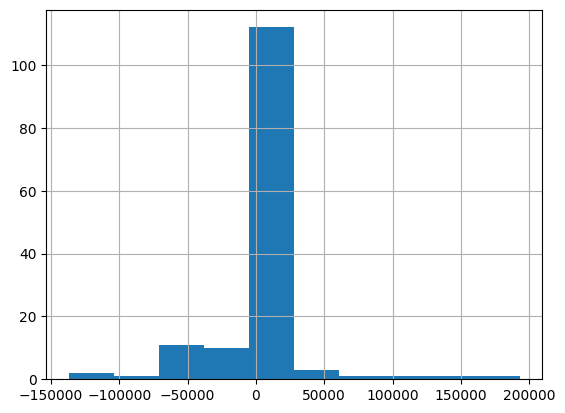

In [ ]:
resid.hist()

In [ ]:
resid.std()

34182.83337390289

In [ ]:
cv = resid.std() / store20.mean() * 100
print(f'{cv:.2f}%')

1.62%


По результатам STL-разложения коэффициент вариации остаточной компоненты составляет 1.62%. Это указывает на крайне низкий уровень необъяснённых колебаний. Практически вся вариация временного ряда объясняется трендом и сезонностью, шум минимален.

# **7. Rolling-window методы**

## 7.1. Что такое rolling-window?

**Rolling-window (скользящее окно)** — это техника анализа временных рядов, при которой мы берём **фиксированное количество последовательных наблюдений** и вычисляем по ним какую-либо статистику (среднее, медиану, стандартное отклонение, сумму и т.д.). После этого окно сдвигается на одну точку, и вычисления повторяются.

### Зачем это нужно?

1. **Сглаживание ряда**: помогает увидеть долгосрочные тренды, убрав краткосрочные колебания.
2. **Анализ локальной вариативности**: стандартное отклонение по окну показывает локальный «шум».
3. **Выявление сезонности или аномалий**: скользящие показатели позволяют сравнивать текущие значения с локальным контекстом.

### Как работает на практике?

Представим ряд продаж за 7 дней:

| День | Продажи |
| ---- | ------- |
| 1    | 10      |
| 2    | 12      |
| 3    | 15      |
| 4    | 14      |
| 5    | 18      |
| 6    | 20      |
| 7    | 22      |

#### Пример: rolling mean с окном = 3

Берём 3 последовательных дня и считаем среднее:

1. Среднее дней 1–3: (10+12+15)/3 = 12.33
2. Среднее дней 2–4: (12+15+14)/3 = 13.67
3. Среднее дней 3–5: (15+14+18)/3 = 15.67
4. Среднее дней 4–6: (14+18+20)/3 = 17.33
5. Среднее дней 5–7: (18+20+22)/3 = 20.00

То есть мы получили новый ряд «скользящего среднего»:

| День | Rolling Mean (3) |
| ---- | ---------------- |
| 3    | 12.33            |
| 4    | 13.67            |
| 5    | 15.67            |
| 6    | 17.33            |
| 7    | 20.00            |

In [3]:
# Создаём временной ряд
sales = pd.Series([10, 12, 15, 14, 18, 20, 22])

# Скользящее среднее с окном 3
rolling_mean = sales.rolling(window=3).mean()

print(rolling_mean)

0          NaN
1          NaN
2    12.333333
3    13.666667
4    15.666667
5    17.333333
6    20.000000
dtype: float64



* `NaN` появляется в первых двух точках, потому что для первых двух дней недостаточно данных для окна в 3 элемента.
* Теперь можно видеть тренд и сглаживание коротких колебаний.

In [ ]:

# Пример: rolling std (локальная волатильность)

# Скользящее стандартное отклонение
rolling_std = sales.rolling(window=3).std()
print(rolling_std)

0         NaN
1         NaN
2    2.516611
3    1.527525
4    2.081666
5    3.055050
6    2.000000
dtype: float64



* Показывает локальную изменчивость ряда в окне из 3 дней.
* Высокое значение → резкие колебания; низкое → более стабильный период.

### Основные моменты

1. **Размер окна** (`window`) критически влияет на результат:

   * Малое окно → чувствительно к краткосрочным изменениям, «шумит».
   * Большое окно → сильное сглаживание, медленно реагирует на изменения.
2. Можно применять **любые агрегирующие функции**:

   * `.sum()`, `.mean()`, `.median()`, `.std()`, `.min()`, `.max()`, пользовательские функции через `.apply()`.
3. Часто используется для **детектирования аномалий, сезонности и трендов** без сложного моделирования.

## 7.2. Зачем rolling-window нужны для сезонности?

Сезонность — это повторяющийся паттерн. Чтобы увидеть этот паттерн:

* нужно сгладить случайный шум
* нужно выделить локальные колебания
* нужно сравнить год с годом или месяц с месяцем

Rolling-window делает именно это.

**Скользящее окно выполняет роль локального сглаживания**, благодаря чему сезонные волны становятся намного лучше видны.

## 7.3. Какие rolling-метрики помогают увидеть сезонность?

### **Rolling mean (скользящее среднее)**

Позволяет увидеть:

* длительные волны продаж
* циклические подъемы и спады
* повторяющиеся паттерны

Если после сглаживания появляется «волна» — это сезонность.

---

### **Rolling sum / rolling median**

Используются, если:

* данные шумные
* есть выбросы
* продажи дискретные

Rolling median хорошо чистит шум → сезонность становится видна даже там, где raw-данные хаотичны.

---

### **Rolling std / rolling variance**

Помогает оценить **сезонную вариативность**.

Если стандартное отклонение растёт каждый год в одни и те же месяцы — это тоже сезонность, только не в уровне, а в **волатильности**.

---

### **Rolling coefficient of variation (CV)**

Используется для формальной оценки:

$$
CV = \frac{\text{rolling std}}{\text{rolling mean}}
$$

* CV растёт → сезонность усиливается
* CV падает → сезонность исчезает

Это особенно важно для розницы (продажи), логистики и складов.

## 7.4. Rolling-методы ≠ STL

STL — это модель разложения.
Rolling — это визуальное, интуитивное, предварительное исследование.

Обычно workflow такой:

1. Сначала смотрим rolling mean → видим волны
2. Затем строим сезонные профили по неделям/месяцам
3. И только потом применяем STL или ARIMA

Rolling помогает понять, **есть ли смысл строить сложную модель**.

## 7.5. Пример

In [4]:
df = pd.read_csv("https://github.com/cpython-projects/da_1709/raw/refs/heads/main/Walmart.csv")
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.set_index('Date').sort_index()

In [5]:
ts = df['Weekly_Sales']
ts

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-05,2193048.75
2010-02-05,536006.73
2010-02-05,789036.02
2010-02-05,465108.52
...,...
2012-10-26,688940.94
2012-10-26,319550.77
2012-10-26,921264.52


In [6]:
# Скользящее среднее с окном в 7 days
rolling_mean = ts.rolling(window=7).mean()

rolling_df = rolling_mean.to_frame("rolling_avg").reset_index()
rolling_df["week"] = rolling_df["Date"].dt.isocalendar().week

# Среднее по каждой неделе года на основе скользящего среднего
weekly_profile_rolling = rolling_df.groupby("week")["rolling_avg"].mean().reset_index()

In [8]:
# Скользящее среднее с окном в 28 days
rolling_mean1 = ts.rolling(window=28).mean()

rolling_df1 = rolling_mean1.to_frame("rolling_avg").reset_index()
rolling_df1["week"] = rolling_df["Date"].dt.isocalendar().week

# Среднее по каждой неделе года на основе скользящего среднего
weekly_profile_rolling1 = rolling_df1.groupby("week")["rolling_avg"].mean().reset_index()

In [7]:
fig = px.line(
    weekly_profile_rolling,
    x="week",
    y="rolling_avg",
    title="Недельный сезонный профиль продаж Walmart (28-day rolling)",
    labels={"rolling_avg": "avg weekly sales (rolling)", "week": "week number"}
)
fig.show()

In [9]:
fig = px.line(
    weekly_profile_rolling1,
    x="week",
    y="rolling_avg",
    title="Недельный сезонный профиль продаж Walmart (28-day rolling)",
    labels={"rolling_avg": "avg weekly sales (rolling)", "week": "week number"}
)
fig.show()